# Utilities

In [2]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import matplotlib as mpl
from scipy.integrate import odeint
from numpy import linalg as LA
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
mpl.rcdefaults() 
from scipy.stats import uniform
import scipy.stats as st
from matplotlib import colors
from matplotlib import cm
import pandas as pd
import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy
import json
import xarray as xr
import pickle
from scipy.stats import linregress
from EWS_functions import *
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

jtplot.style(context='paper', fscale=1.4, spines=True, grid=False, ticks=True,gridlines='--')

fontsize=16
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.labelsize']= 'x-large'
mpl.rcParams['figure.facecolor']='white'

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
hfont = {'fontname':'Arial'}

mpl.rcParams['text.latex.preamble']= r'\usepackage{amsmath}'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']) 

## EWS functions

In [1]:
def get_EWS(time,data,trend,ws):
    linfits = []
    ps = []
    bound = ws // 2
    
    std = runstd(data - trend, ws)[bound:-bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-2], std[:-2], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(std[:-2], 1000, p0))
    
    ar1 = runac(data - trend, ws)[bound : -bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-3], ar1[:-3], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(ar1[:-2], 1000, p0))
    
    lam = run_fit_a_ar1(data-trend,ws)[bound:-bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-2], lam[:-2], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(lam[:-2], 1000, p0))
    
    return std, ar1, lam, linfits, ps

In [4]:
def plot_EWS(data, timess, ws=70, col='k',lbl='',alph=1,lw=1):
    bound = ws // 2
#     popt, cov = curve_fit(funcfit3, timess, data, p0 = [-8.33097773e-01,  1.05507897e-02,  2.02518923e+03], maxfev = 1000000000)
#     trend = funcfit3(timess, *popt)
    trend = gaussian_filter1d(data, 10)

    std, ar1, lam, linfits, ps = get_EWS(timess,data,trend,ws)

    ax1.plot(timess[bound : -bound],std,color=col,label=lbl,alpha=alph,lw=lw)
    pv = kendall_tau_test(std[:-2],1000,linfits[1][0])
    ax1.plot(timess[bound : -bound][:-2],linfits[0][0] * timess[bound : -bound][:-2] + linfits[0][1],linestyle='--',color=col,alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

    ax2.plot(timess[bound : -bound],ar1,color=col,label=lbl,alpha=alph,lw=lw)
    pv = kendall_tau_test(ar1[:-2],1000,linfits[1][0])
    ax2.plot(timess[bound : -bound][:-2],linfits[1][0] * timess[bound : -bound][:-2] + linfits[1][1],linestyle='--',color=col,alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

    ax3.plot(timess[bound : -bound],lam,color=col,label=lbl,alpha=alph,lw=lw)
    p0, p1, p2 = np.polyfit(timess[bound : -bound][:-2], lam[:-2], 2)
    pl0, pl1  = np.polyfit(timess[bound : -bound][:-2], lam[:-2], 1)
    pv = kendall_tau_test(lam[:-2], 1000, pl0) # precentile of 1000 fourier surrogates have a larger linear slope
#     ax3.plot(timess[bound : -bound][:-2], p0 * timess[bound : -bound][:-2]**2+p1 * timess[bound : -bound][:-2] + p2, color=col,linestyle='--',alpha=alph,lw=lw,label="p = {:.3f}".format(pv))
    ax3.plot(timess[bound : -bound][:-2], pl0 * timess[bound : -bound][:-2] + pl1, color=col,linestyle='--',alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

## plotting

In [5]:
def plot_pies(N_tot, N_all, N_s26, N_s35, N_indx, N_any, N_strns, N_strn35indx, N_strn26indx):
    fig = plt.figure(figsize=(10,5))
    gs = fig.add_gridspec(3, 3)
    ax = fig.add_subplot(gs[0,0])
    data = [N_all,N_tot-N_all]
    patches, texts= ax.pie(
        data,
            colors = ['C1','lightgrey'],
        wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
        textprops={'size': 'x-large'})
    ax.set_title('All Three\n{}/{}'.format(N_all,N_tot))

    ax = fig.add_subplot(gs[0,1])
    data = [N_any,N_tot-N_any]
    patches, texts= ax.pie(
    data,
        colors = ['C4','lightgrey'],
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'})
    ax.set_title('Any\n{}/{}'.format(N_any,N_tot))

    ax = fig.add_subplot(gs[1,0])
    data = [N_s26,N_tot-N_s26]
    patches, texts= ax.pie(
    data,
    colors = ['C0','lightgrey'],
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'})
    ax.set_title('Strn26\n{}/{}'.format(N_s26,N_tot))

    ax = fig.add_subplot(gs[1,1])
    data = [N_s35,N_tot-N_s35]
    patches, texts= ax.pie(
    data,
        colors = ['C2','lightgrey'],
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'})
    ax.set_title('Strn35\n{}/{}'.format(N_s35,N_tot))

    ax = fig.add_subplot(gs[1,2])
    data = [N_indx,N_tot-N_indx]
    patches, texts= ax.pie(
    data,
        colors = ['C3','lightgrey'],
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'})
    ax.set_title('Index\n{}/{}'.format(N_indx,N_tot))



    ax = fig.add_subplot(gs[2,0])
    data = [N_strns,N_tot-N_strns]
    patches, texts= ax.pie(
    data,
    colors = ['C5','lightgrey'],
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'})
    ax.set_title('Strn26 & Strn35\n{}/{}'.format(N_strns,N_tot))

    ax = fig.add_subplot(gs[2,1])
    data = [N_strn35indx,N_tot-N_strn35indx]
    patches, texts= ax.pie(
    data,
        colors = ['C6','lightgrey'],
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'})
    ax.set_title('Strn35 & Index\n{}/{}'.format(N_strn35indx,N_tot))

    ax = fig.add_subplot(gs[2,2])
    data = [N_strn26indx,N_tot-N_strn26indx]
    patches, texts= ax.pie(
    data,
        colors = ['C7','lightgrey'],
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'x-large'})
    ax.set_title('Strn 26 & Index\n{}/{}'.format(N_strn26indx,N_tot))


    fig.subplots_adjust(hspace=1)
    fig.suptitle('All Models',fontsize=20,fontweight='bold',y=1.1)
    plt.show()

# Get Data

In [6]:
ds = xr.open_dataset('CMIP6_amoc.nc')

In [7]:
strn26 = ds.strength_265N
strn35 = ds.strength_35N
index = ds.index

In [8]:
strn26.load()
strn35.load()
index.load()

<xarray.DataArray 'index' (models: 34, ensemble_members: 10, year: 165)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[ -9.83567818,  -9.96747804,  -9.87559962, ...,  -9.8192265 ,
          -9.53018165,  -9.60423207],
        [ -9.26724124,  -9.20765185,  -9.62124856, ..., -10.28693318,
         -10.51233848, -10.22079849],
        [ -9.45160929,  -9.45961754,  -9.54747669, ..., -10.22823318,
         -10.1423463 ,  -9.9231437 ],
...
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[ -8.9466881 ,  -9.2422324 ,  -9.27880526, ...,  -9.5742743 ,
          -9.38110113,  -9.47151629],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * models            (models) object 'AWI-CM-1-1-MR' ... 'SAM0-UNICON'
  * year              (year) int64 1850 1851 1852 1853 ... 2011 2012 2013 2014
  * ensemble_members  (ensemble_members) object 'r1i1p1f1' ... 'r10i1p1f1'

limit_output extension: Maximum message size of 10000 exceeded with 18219 characters

In [9]:
yrs = strn26.year.values
models = strn26.models.values
ensembs = strn26.ensemble_members.values

# Make EWS files

In [10]:
def make_var_array(data,ws=70,gedge=5):
    varss = np.full((data.shape[0],data.shape[1],data.shape[2]-2*gedge),np.nan)
    for i in np.arange(0,data.shape[0]):
        for j in np.arange(0,data.shape[1]):
            amoc = np.nan_to_num(data[i,j].values)
            amoc_low = gaussian_filter1d(amoc, 10)
            if amoc.sum() != 0:
                std = runstd((amoc-amoc_low)[gedge:-gedge], ws)
                varss[i,j,:]=std
    return varss

In [11]:
def make_var_pvs_array(varss,time,ws=70):
    bound = ws // 2
    tt = time[bound:-bound]
    var_pvs = np.full((varss.shape[0],varss.shape[1]),np.nan)
    var_trends = np.full((varss.shape[0],varss.shape[1]),np.nan)
    for i in np.arange(0,varss.shape[0]):
        for j in np.arange(0,varss.shape[1]):
            std = np.nan_to_num(varss[i,j,:][bound : -bound].values)
            if std.sum() != 0:
                p0, p1 = np.polyfit(tt[:-2], std[:-2], 1)
                pv = kendall_tau_test(std[:-2], 10000, p0)
                var_pvs[i,j]=pv
                var_trends[i,j]=p0
    return var_pvs, var_trends

In [12]:
def make_ar1_array(data,ws=70,gedge=5):
    ar1s = np.full((data.shape[0],data.shape[1],data.shape[2]-2*gedge),np.nan)
    for i in np.arange(0,data.shape[0]):
        for j in np.arange(0,data.shape[1]):
            amoc = np.nan_to_num(data[i,j].values)
            amoc_low = gaussian_filter1d(amoc, 10)
            if amoc.sum() != 0:
                ar1 = runac((amoc-amoc_low)[gedge:-gedge], ws)
                ar1s[i,j,:]=ar1
    return ar1s

In [13]:
def make_ar1_pvs_array(ar1s,time,ws=70):
    bound = ws // 2
    tt = time[bound:-bound]
    ar1_pvs = np.full((ar1s.shape[0],ar1s.shape[1]),np.nan)
    ar1_trends = np.full((ar1s.shape[0],ar1s.shape[1]),np.nan)
    for i in np.arange(0,ar1s.shape[0]):
        for j in np.arange(0,ar1s.shape[1]):
            ar1 = np.nan_to_num(ar1s[i,j,:][bound : -bound].values)
            if ar1.sum() != 0:
                p0, p1 = np.polyfit(tt[:-2], ar1[:-2], 1)
                pv = kendall_tau_test(ar1[:-2], 10000, p0)
                ar1_pvs[i,j]=pv
                ar1_trends[i,j]=p0
    return ar1_pvs, ar1_trends

## lambda

In [14]:
# strn26_var = make_var_array(strn26)
# strn35_var = make_var_array(strn35)
# index_var = make_var_array(index)
# vars = xr.Dataset(
#     data_vars = dict(index_var=(['models','ensemble_members','time'],index_var),
#                      strn35_var=(['models','ensemble_members','time'],strn35_var),
#                      strn26_var=(['models','ensemble_members','time'],strn26_var)),
#     coords = dict(
#             time = xr.DataArray(index.year[5:-5].values, dims="time", coords=dict(time=("time", index.year[5:-5].values))),
#             models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
#             ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
#     attrs = dict(
#     description='var for amoc strengths and index.\n Detrending: gaussian filter with sigma of 10 (5 yrs removed on each side)\n Window size 70 yrs')
# )
# vars.to_netcdf('EWS_files/CMIP6_vars.nc')

In [15]:
# strn26_ar1 = make_ar1_array(strn26)
# strn35_ar1 = make_ar1_array(strn35)
# index_ar1 = make_ar1_array(index)
# ar1s = xr.Dataset(
#     data_vars = dict(index_ar1=(['models','ensemble_members','time'],index_ar1),
#                      strn35_ar1=(['models','ensemble_members','time'],strn35_ar1),
#                      strn26_ar1=(['models','ensemble_members','time'],strn26_ar1)),
#     coords = dict(
#             time = xr.DataArray(index.year[5:-5].values, dims="time", coords=dict(time=("time", index.year[5:-5].values))),
#             models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
#             ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
#     attrs = dict(
#     description='ar1 for amoc strengths and index.\n Detrending: gaussian filter with sigma of 10 (5 yrs removed on each side)\n Window size 70 yrs')
# )
# ar1s.to_netcdf('EWS_files/CMIP6_ar1s.nc')

## trends and pvs of linear trend

In [16]:
# varss = xr.open_dataset('EWS_files/CMIP6_vars.nc')

# strn26_pvs, strn26_trends = make_var_pvs_array(varss.strn26_var,varss.time)
# strn35_pvs, strn35_trends = make_var_pvs_array(varss.strn35_var,varss.time)
# index_pvs, index_trends = make_var_pvs_array(varss.index_var,varss.time)

# var_pvs = xr.Dataset(
#     data_vars = dict(index_pvs=(['models','ensemble_members'],index_pvs),
#                      strn35_pvs=(['models','ensemble_members'],strn35_pvs),
#                      strn26_pvs=(['models','ensemble_members'],strn26_pvs)),
#     coords = dict(
#             models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
#             ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
#     attrs = dict(
#     description='Kendall Tau test P for variance of amoc strengths and index.\n Using 10000 fourier surrogates')
# )
# var_pvs.to_netcdf('EWS_files/CMIP6_var_pvs.nc')

# var_trends = xr.Dataset(
#     data_vars = dict(index_trends=(['models','ensemble_members'],index_trends),
#                      strn35_trends=(['models','ensemble_members'],strn35_trends),
#                      strn26_trends=(['models','ensemble_members'],strn26_trends)),
#     coords = dict(
#             models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
#             ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
#     attrs = dict(
#     description='Linear slope for vars of amoc strengths and index.')
    
# )
# var_trends.to_netcdf('EWS_files/CMIP6_var_trends.nc')

In [17]:
# # ar1ss = xr.open_dataset('EWS_files/CMIP6_ar1s.nc')

# # strn26_pvs, strn26_trends = make_ar1_pvs_array(ar1ss.strn26_ar1,ar1ss.time)
# # strn35_pvs, strn35_trends = make_ar1_pvs_array(ar1ss.strn35_ar1,ar1ss.time)
# # index_pvs, index_trends = make_ar1_pvs_array(ar1ss.index_ar1,ar1ss.time)

# ar1_pvs = xr.Dataset(
#     data_vars = dict(index_pvs=(['models','ensemble_members'],index_pvs),
#                      strn35_pvs=(['models','ensemble_members'],strn35_pvs),
#                      strn26_pvs=(['models','ensemble_members'],strn26_pvs)),
#     coords = dict(
#             models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
#             ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
#     attrs = dict(
#     description='Kendall Tau test P for ar1 of amoc strengths and index.\n Using 10000 fourier surrogates')
# )
# ar1_pvs.to_netcdf('EWS_files/CMIP6_ar1_pvs.nc')

# ar1_trends = xr.Dataset(
#     data_vars = dict(index_trends=(['models','ensemble_members'],index_trends),
#                      strn35_trends=(['models','ensemble_members'],strn35_trends),
#                      strn26_trends=(['models','ensemble_members'],strn26_trends)),
#     coords = dict(
#             models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
#             ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
#     attrs = dict(
#     description='Linear slope for ar1s of amoc strengths and index.')
    
# )
# ar1_trends.to_netcdf('EWS_files/CMIP6_ar1_trends.nc')

# variance

In [168]:
var_pvs = xr.open_dataset('EWS_files/CMIP6_var_pvs.nc')
ar1_pvs = xr.open_dataset('EWS_files/CMIP6_ar1_pvs.nc')

In [26]:
min_pv = 0.05

var_EWS_all = var_pvs.where(
           ((var_pvs.strn26_pvs<=min_pv)&
            (var_pvs.strn35_pvs<=min_pv)&
            (var_pvs.index_pvs<=min_pv)))
var_EWS_strn26 = var_pvs.where(
           (var_pvs.strn26_pvs<=min_pv))
var_EWS_strn35 = var_pvs.where(
           (var_pvs.strn35_pvs<=min_pv))
var_EWS_index = var_pvs.where(
           (var_pvs.index_pvs<=min_pv))

var_EWS_any = var_pvs.where(
           ((var_pvs.strn26_pvs<=min_pv) |
            (var_pvs.strn35_pvs<=min_pv) |
            (var_pvs.index_pvs<=min_pv)))
var_EWS_strns = var_pvs.where(
           (var_pvs.strn26_pvs<=min_pv)&
            (var_pvs.strn35_pvs<=min_pv))
var_EWS_strn35indx = var_pvs.where(
           (var_pvs.strn35_pvs<=min_pv)&
            (var_pvs.index_pvs<=min_pv))
var_EWS_strn26indx = var_pvs.where(
           (var_pvs.strn26_pvs<=min_pv)&
            (var_pvs.index_pvs<=min_pv))

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


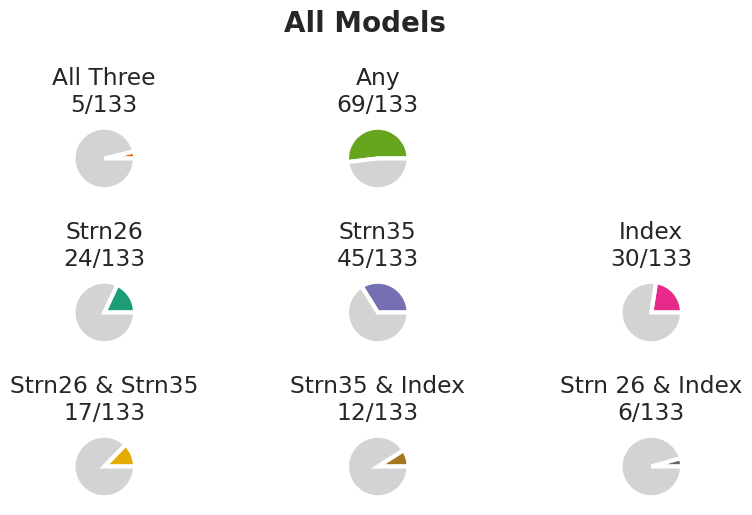

In [27]:
N_tot = np.count_nonzero(~np.isnan(var_pvs.strn26_pvs.values))
N_all = np.count_nonzero(~np.isnan(var_EWS_all.strn26_pvs.values))
N_s26 = np.count_nonzero(~np.isnan(var_EWS_strn26.strn26_pvs.values))
N_s35 = np.count_nonzero(~np.isnan(var_EWS_strn35.strn26_pvs.values))
N_indx = np.count_nonzero(~np.isnan(var_EWS_index.strn26_pvs.values))
N_any = np.count_nonzero(~np.isnan(var_EWS_any.strn26_pvs.values))
N_strns = np.count_nonzero(~np.isnan(var_EWS_strns.strn26_pvs.values))
N_strn35indx = np.count_nonzero(~np.isnan(var_EWS_strn35indx.strn26_pvs.values))
N_strn26indx = np.count_nonzero(~np.isnan(var_EWS_strn26indx.strn26_pvs.values))

plot_pies(N_tot, N_all, N_s26, N_s35, N_indx, N_any, N_strns, N_strn35indx, N_strn26indx)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


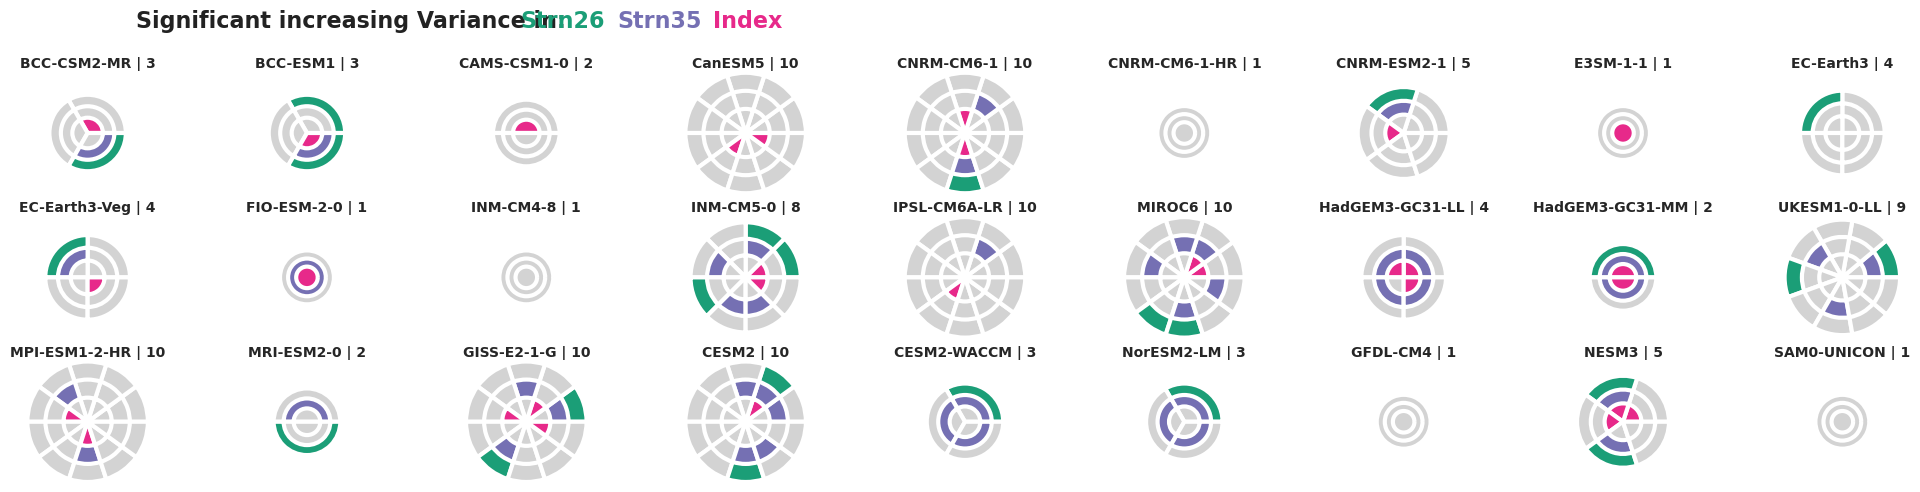

In [28]:
radius_one = 0.3
# for modls in [models[0:12],models[12:22],models[22:]]:
fig = plt.figure(figsize=(25,5))
gs = fig.add_gridspec(3, 9)
ir = 0

for im, model in enumerate(models):
    idc = np.where(~np.isnan(var_pvs.strn26_pvs.sel(models=model).values))
    n_tot = np.count_nonzero(~np.isnan(var_pvs.strn26_pvs.sel(models=model).values))
#         n_all = np.count_nonzero(~np.isnan(var_EWS_all.strn26_pvs.sel(models=model).values))
#         n_s26 = np.count_nonzero(~np.isnan(var_EWS_strn26.strn26_pvs.sel(models=model).values))
#         n_s35 = np.count_nonzero(~np.isnan(var_EWS_strn35.strn26_pvs.sel(models=model).values))
#         n_indx = np.count_nonzero(~np.isnan(var_EWS_index.strn26_pvs.sel(models=model).values))

    radius = 0.3+0.4*np.sqrt(n_tot)

    if n_tot!= 0:
        if ir<=8:
            ax = fig.add_subplot(gs[0,ir])
        if (ir>=9) & (ir<=17):
            ax = fig.add_subplot(gs[1,ir-9])
        if ir>=18:
            ax = fig.add_subplot(gs[2,ir-18])

        ax.set_title('{} | {}'.format(model,n_tot),fontsize=10,fontweight='bold',y=1.1)
        
        colorss = ['C0','C2','C3']
        rads = [1,0.7,0.4]
        datass = [var_EWS_strn26.strn26_pvs,var_EWS_strn35.strn35_pvs,var_EWS_index.index_pvs]
        
        for i, datas in enumerate(datass):
            data = (~np.isnan(datas.sel(models=model).values[idc]))*1
            slices = np.full(len(data),1)
            idc2 = np.where(data==1)
            cols = np.full(len(data),'lightgrey')
            cols[idc2] = colorss[i]
            patches, texts= ax.pie(
            slices,
                radius = rads[i]*radius,
            colors = cols,
            wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
            textprops={'size': 'x-large'})

        ir = ir +1
        
        if ir==1:
            ax.text(1,1.6,'Significant increasing Variance in:',transform=ax.transAxes,fontweight='bold',ma='left',color='k')
            ax.text(5,1.6,'Strn26',transform=ax.transAxes,fontweight='bold',ma='left',color='C0')
            ax.text(6,1.6,'Strn35',transform=ax.transAxes,fontweight='bold',ma='left',color='C2')
            ax.text(7,1.6,'Index',transform=ax.transAxes,fontweight='bold',ma='left',color='C3')
fig.subplots_adjust(hspace=0.5)
#     fig.tight_layout()
fig.patch.set_facecolor("white")
plt.show()

# AR1

In [29]:
min_pv = 0.05

ar1_EWS_all = ar1_pvs.where(
           ((ar1_pvs.strn26_pvs<=min_pv)&
            (ar1_pvs.strn35_pvs<=min_pv)&
            (ar1_pvs.index_pvs<=min_pv)))
ar1_EWS_strn26 = ar1_pvs.where(
           (ar1_pvs.strn26_pvs<=min_pv))
ar1_EWS_strn35 = ar1_pvs.where(
           (ar1_pvs.strn35_pvs<=min_pv))
ar1_EWS_index = ar1_pvs.where(
           (ar1_pvs.index_pvs<=min_pv))

ar1_EWS_any = ar1_pvs.where(
           ((ar1_pvs.strn26_pvs<=min_pv) |
            (ar1_pvs.strn35_pvs<=min_pv) |
            (ar1_pvs.index_pvs<=min_pv)))
ar1_EWS_strns = ar1_pvs.where(
           (ar1_pvs.strn26_pvs<=min_pv)&
            (ar1_pvs.strn35_pvs<=min_pv))
ar1_EWS_strn35indx = ar1_pvs.where(
           (ar1_pvs.strn35_pvs<=min_pv)&
            (ar1_pvs.index_pvs<=min_pv))
ar1_EWS_strn26indx = ar1_pvs.where(
           (ar1_pvs.strn26_pvs<=min_pv)&
            (ar1_pvs.index_pvs<=min_pv))

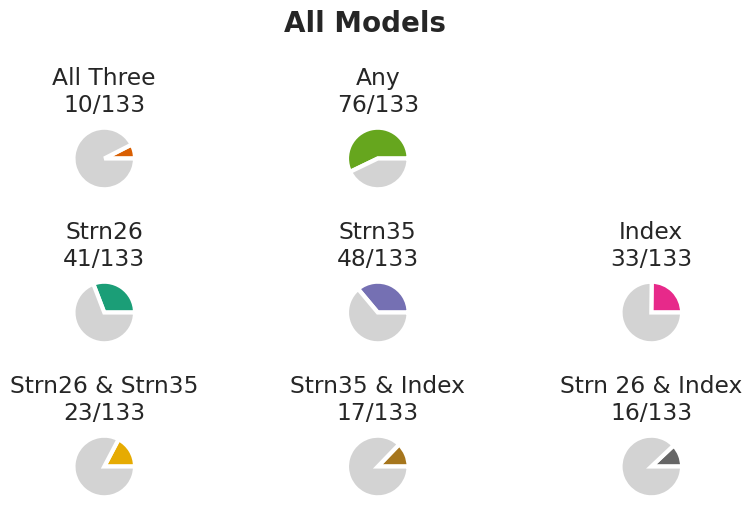

In [30]:
N_tot = np.count_nonzero(~np.isnan(ar1_pvs.strn26_pvs.values))
N_all = np.count_nonzero(~np.isnan(ar1_EWS_all.strn26_pvs.values))
N_s26 = np.count_nonzero(~np.isnan(ar1_EWS_strn26.strn26_pvs.values))
N_s35 = np.count_nonzero(~np.isnan(ar1_EWS_strn35.strn26_pvs.values))
N_indx = np.count_nonzero(~np.isnan(ar1_EWS_index.strn26_pvs.values))
N_any = np.count_nonzero(~np.isnan(ar1_EWS_any.strn26_pvs.values))
N_strns = np.count_nonzero(~np.isnan(ar1_EWS_strns.strn26_pvs.values))
N_strn35indx = np.count_nonzero(~np.isnan(ar1_EWS_strn35indx.strn26_pvs.values))
N_strn26indx = np.count_nonzero(~np.isnan(ar1_EWS_strn26indx.strn26_pvs.values))

plot_pies(N_tot, N_all, N_s26, N_s35, N_indx, N_any, N_strns, N_strn35indx, N_strn26indx)

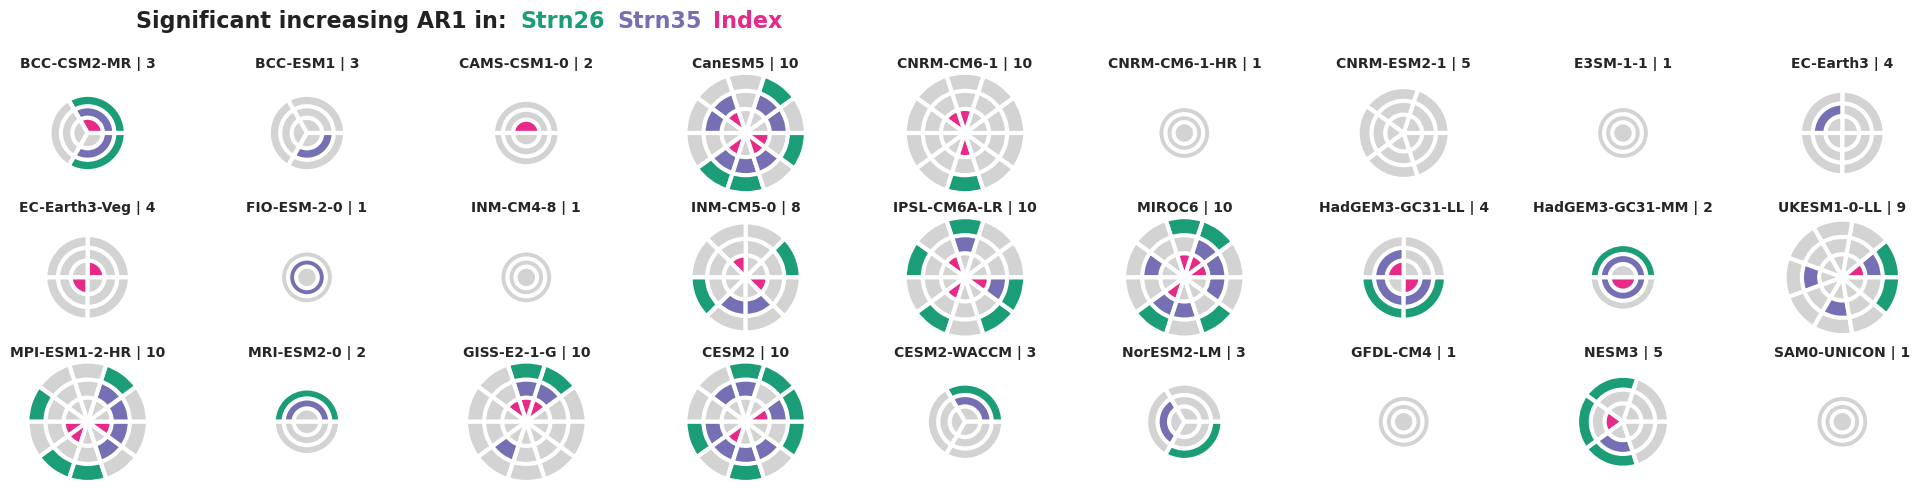

In [31]:
radius_one = 0.3
# for modls in [models[0:12],models[12:22],models[22:]]:
fig = plt.figure(figsize=(25,5))
gs = fig.add_gridspec(3, 9)
ir = 0

for im, model in enumerate(models):
    idc = np.where(~np.isnan(ar1_pvs.strn26_pvs.sel(models=model).values))
    n_tot = np.count_nonzero(~np.isnan(ar1_pvs.strn26_pvs.sel(models=model).values))
#         n_all = np.count_nonzero(~np.isnan(ar1_EWS_all.strn26_pvs.sel(models=model).values))
#         n_s26 = np.count_nonzero(~np.isnan(ar1_EWS_strn26.strn26_pvs.sel(models=model).values))
#         n_s35 = np.count_nonzero(~np.isnan(ar1_EWS_strn35.strn26_pvs.sel(models=model).values))
#         n_indx = np.count_nonzero(~np.isnan(ar1_EWS_index.strn26_pvs.sel(models=model).values))

    radius = 0.3+0.4*np.sqrt(n_tot)

    if n_tot!= 0:
        if ir<=8:
            ax = fig.add_subplot(gs[0,ir])
        if (ir>=9) & (ir<=17):
            ax = fig.add_subplot(gs[1,ir-9])
        if ir>=18:
            ax = fig.add_subplot(gs[2,ir-18])

        ax.set_title('{} | {}'.format(model,n_tot),fontsize=10,fontweight='bold',y=1.1)
        
        colorss = ['C0','C2','C3']
        rads = [1,0.7,0.4]
        datass = [ar1_EWS_strn26.strn26_pvs,ar1_EWS_strn35.strn35_pvs,ar1_EWS_index.index_pvs]
        
        for i, datas in enumerate(datass):
            data = (~np.isnan(datas.sel(models=model).values[idc]))*1
            slices = np.full(len(data),1)
            idc2 = np.where(data==1)
            cols = np.full(len(data),'lightgrey')
            cols[idc2] = colorss[i]
            patches, texts= ax.pie(
            slices,
                radius = rads[i]*radius,
            colors = cols,
            wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
            textprops={'size': 'x-large'})

        ir = ir +1
        
        if ir==1:
            ax.text(1,1.6,'Significant increasing AR1 in:',transform=ax.transAxes,fontweight='bold',ma='left',color='k')
            ax.text(5,1.6,'Strn26',transform=ax.transAxes,fontweight='bold',ma='left',color='C0')
            ax.text(6,1.6,'Strn35',transform=ax.transAxes,fontweight='bold',ma='left',color='C2')
            ax.text(7,1.6,'Index',transform=ax.transAxes,fontweight='bold',ma='left',color='C3')
fig.subplots_adjust(hspace=0.5)
#     fig.tight_layout()
fig.patch.set_facecolor("white")
plt.show()

# all indicators

In [32]:
lambdas = xr.open_dataset('EWS_files/CMIP6_lambdas.nc')
lambda_pvs = xr.open_dataset('EWS_files/CMIP6_lambda_pvs.nc')
lambda_trends = xr.open_dataset('EWS_files/CMIP6_lambda_trends.nc')

In [33]:
EWS_names = ['lambda','var','ar1']
index_names = ['index','strn35','strn26']

In [35]:
# all_EWS = xr.Dataset(
#     data_vars = dict(signal=(['EWS','indices','models','ensemble_members','time'],np.stack([lambdas.to_array().values,varss.to_array().values,ar1s.to_array().values])),
#                      pvs=(['EWS','indices','models','ensemble_members'],np.stack([lambda_pvs.to_array().values,var_pvs.to_array().values,ar1_pvs.to_array().values])),
#                      trends=(['EWS','indices','models','ensemble_members'],np.stack([lambda_trends.to_array().values,var_trends.to_array().values,ar1_trends.to_array().values]))),
#     coords = dict(
#             time = xr.DataArray(index.year[5:-5].values, dims="time", coords=dict(time=("time", index.year[5:-5].values))),
#             EWS = xr.DataArray(EWS_names, dims="EWS", coords=dict(EWS=("EWS", EWS_names))),
#             indices = xr.DataArray(index_names, dims="indices", coords=dict(indices=("indices", index_names))),
#             models      = xr.DataArray(models, dims="models", coords=dict(models=("models", models))),
#             ensemble_members = xr.DataArray(ensembs, dims="ensemble_members", coords=dict(ensemble_members=("ensemble_members", ensembs)))),
#     attrs = dict(
#     description='Kendall Tau test P for ar1 of amoc strengths and index.\n Using 10000 fourier surrogates')
# )
# all_EWS.to_netcdf('EWS_files/CMIP6_all_EWS.nc')


In [36]:
all_EWS = xr.open_dataset('EWS_files/CMIP6_all_EWS.nc')

In [37]:
EWS_all = all_EWS.pvs.where(
           ((all_EWS.pvs.sel(indices='strn26')<=0.05)&
            (all_EWS.pvs.sel(indices='strn35')<=0.05)&
            (all_EWS.pvs.sel(indices='index')<=0.05)))
EWS_strn26 = all_EWS.pvs.where(
           (all_EWS.pvs.sel(indices='strn26')<=0.05))
EWS_strn35 = all_EWS.pvs.where(
           (all_EWS.pvs.sel(indices='strn35')<=0.05))
EWS_index = all_EWS.pvs.where(
           (all_EWS.pvs.sel(indices='index')<=0.05))

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


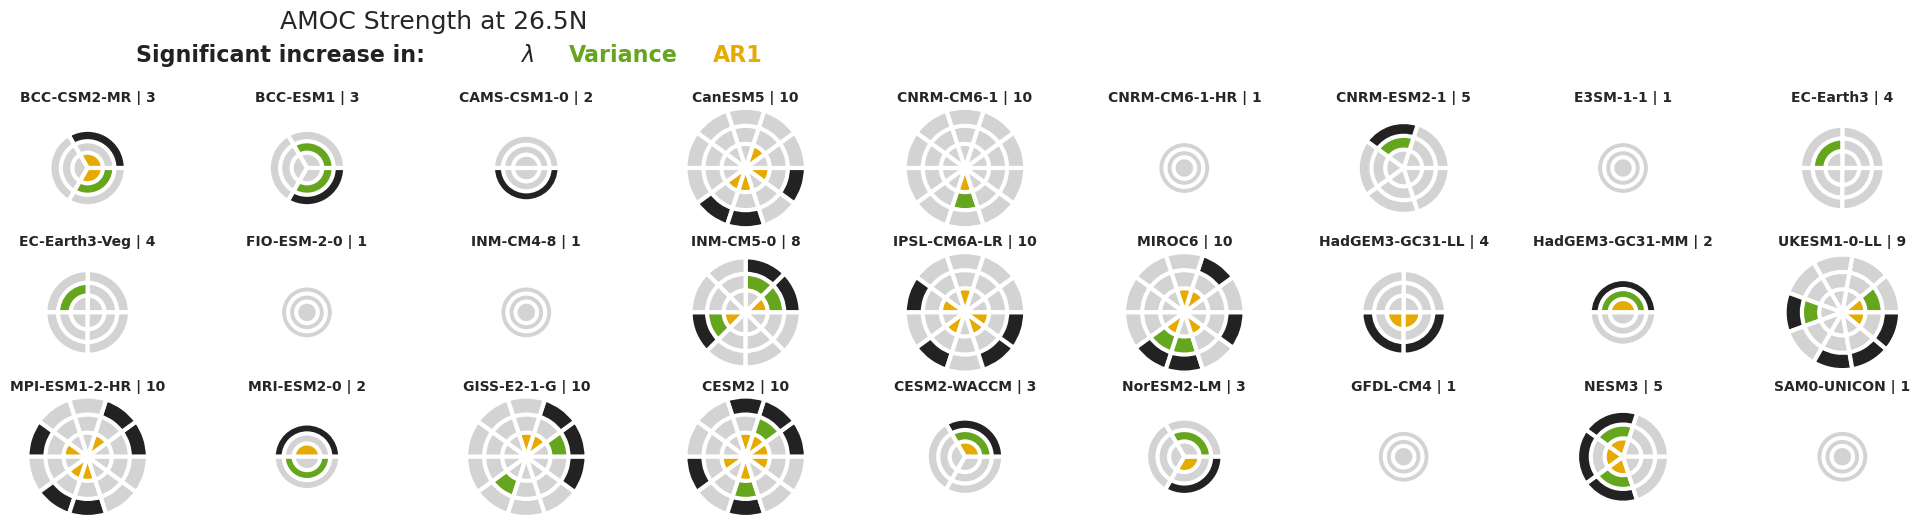

In [38]:
datas = EWS_strn26.sel(indices='strn26')
valuess = all_EWS.pvs.sel(indices='strn26')

fig = plt.figure(figsize=(25,5))
gs = fig.add_gridspec(3, 9)
ir = 0
for im, model in enumerate(models):
    n_tot = np.count_nonzero(~np.isnan(valuess.sel(EWS='var').sel(models=model).values))

    radius = 0.3+0.4*np.sqrt(n_tot)

    if n_tot!= 0:
        if ir<=8:
            ax = fig.add_subplot(gs[0,ir])
        if (ir>=9) & (ir<=17):
            ax = fig.add_subplot(gs[1,ir-9])
        if ir>=18:
            ax = fig.add_subplot(gs[2,ir-18])
            

        ax.set_title('{} | {}'.format(model,n_tot),fontsize=10,fontweight='bold',y=1.1)

        colorss = ['k','C4','C5']
        rads = [1,0.7,0.4]
        ewss = ['lambda','var','ar1']
        idc = np.where(~np.isnan(valuess.sel(EWS='var').sel(models=model).values))

        for i, ews in enumerate(ewss):
            data = (~np.isnan(datas.sel(EWS=ews).sel(models=model).values[idc]))*1
            slices = np.full(len(data),1)
            idc2 = np.where(data==1)
            cols = np.full(len(data),'lightgrey')
            cols[idc2] = colorss[i]
            patches, texts= ax.pie(
            slices,
                radius = rads[i]*radius,
            colors = cols,
            wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
            textprops={'size': 'x-large'})


        ir = ir +1

        if ir==1:
            ax.text(1,1.6,'Significant increase in:',transform=ax.transAxes,fontweight='bold',ma='left',color='k')
            ax.text(5,1.6,'$\lambda$',transform=ax.transAxes,fontweight='bold',ma='left',color='k')
            ax.text(5.5,1.6,'Variance',transform=ax.transAxes,fontweight='bold',ma='left',color='C4')
            ax.text(7,1.6,'AR1',transform=ax.transAxes,fontweight='bold',ma='left',color='C5')
fig.subplots_adjust(hspace=0.5)
#     fig.tight_layout()
fig.patch.set_facecolor("white")

fig.suptitle('AMOC Strength at 26.5N',fontsize=18,y=1.1,x=0.3)
plt.show()

## pies

In [39]:
min_pv = 0.05
indx = 'strn26'
EWS_all_ind = all_EWS.pvs.sel(indices=indx).sel(EWS='lambda').where(
           ((all_EWS.pvs.sel(indices=indx).sel(EWS='lambda')<=min_pv)&
            (all_EWS.pvs.sel(indices=indx).sel(EWS='var')<=min_pv)&
            (all_EWS.pvs.sel(indices=indx).sel(EWS='ar1')<=min_pv)))
EWS_lambda = all_EWS.pvs.sel(indices=indx).sel(EWS='lambda').where(
           (all_EWS.pvs.sel(indices=indx).sel(EWS='lambda')<=min_pv))
EWS_var = all_EWS.pvs.sel(indices=indx).sel(EWS='lambda').where(
           (all_EWS.pvs.sel(indices=indx).sel(EWS='var')<=min_pv))
EWS_ar1 = all_EWS.pvs.sel(indices=indx).sel(EWS='lambda').where(
           (all_EWS.pvs.sel(indices=indx).sel(EWS='ar1')<=min_pv))

EWS_any = all_EWS.pvs.sel(indices=indx).sel(EWS='lambda').where(
           ((all_EWS.pvs.sel(indices=indx).sel(EWS='lambda')<=min_pv) |
            (all_EWS.pvs.sel(indices=indx).sel(EWS='var')<=min_pv) |
            (all_EWS.pvs.sel(indices=indx).sel(EWS='ar1')<=min_pv)))
EWS_lamvar = all_EWS.pvs.sel(indices=indx).sel(EWS='lambda').where(
           (all_EWS.pvs.sel(indices=indx).sel(EWS='lambda')<=min_pv)&
            (all_EWS.pvs.sel(indices=indx).sel(EWS='var')<=min_pv))
EWS_varar1 = all_EWS.pvs.sel(indices=indx).sel(EWS='lambda').where(
           (all_EWS.pvs.sel(indices=indx).sel(EWS='var')<=min_pv)&
            (all_EWS.pvs.sel(indices=indx).sel(EWS='ar1')<=min_pv))
EWS_lamar1 = all_EWS.pvs.sel(indices=indx).sel(EWS='lambda').where(
           (all_EWS.pvs.sel(indices=indx).sel(EWS='lambda')<=min_pv)&
            (all_EWS.pvs.sel(indices=indx).sel(EWS='ar1')<=min_pv))
N_tot = np.count_nonzero(~np.isnan(all_EWS.pvs.sel(EWS='ar1').sel(indices=indx).values))
N_all = np.count_nonzero(~np.isnan(EWS_all_ind.values))
N_lam = np.count_nonzero(~np.isnan(EWS_lambda.values))
N_var = np.count_nonzero(~np.isnan(EWS_var.values))
N_ar1 = np.count_nonzero(~np.isnan(EWS_ar1 .values))
N_any = np.count_nonzero(~np.isnan(EWS_any.values))
N_lamvar = np.count_nonzero(~np.isnan(EWS_lamvar.values))
N_varar1 = np.count_nonzero(~np.isnan(EWS_varar1.values))
N_lamar1 = np.count_nonzero(~np.isnan(EWS_lamar1.values))

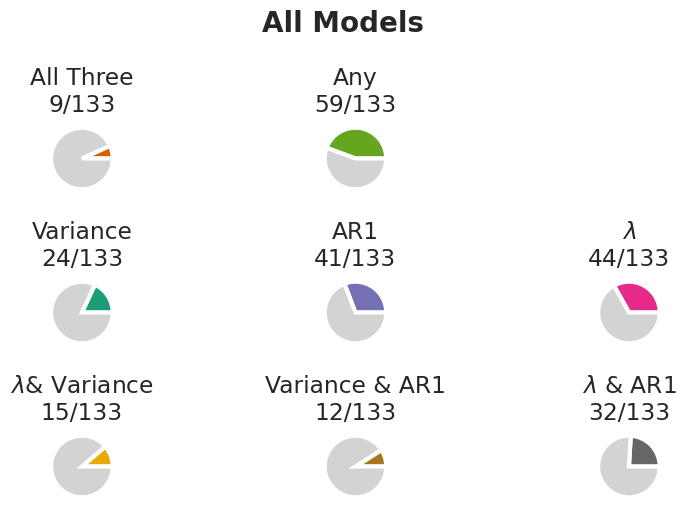

In [40]:
N_tot = np.count_nonzero(~np.isnan(all_EWS.pvs.sel(EWS='ar1').sel(indices=indx).values))
N_all = np.count_nonzero(~np.isnan(EWS_all_ind.values))
N_lam = np.count_nonzero(~np.isnan(EWS_lambda.values))
N_var = np.count_nonzero(~np.isnan(EWS_var.values))
N_ar1 = np.count_nonzero(~np.isnan(EWS_ar1 .values))
N_any = np.count_nonzero(~np.isnan(EWS_any.values))
N_lamvar = np.count_nonzero(~np.isnan(EWS_lamvar.values))
N_varar1 = np.count_nonzero(~np.isnan(EWS_varar1.values))
N_lamar1 = np.count_nonzero(~np.isnan(EWS_lamar1.values))

fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(3, 3)
ax = fig.add_subplot(gs[0,0])
data = [N_all,N_tot-N_all]
patches, texts= ax.pie(
data,
    colors = ['C1','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('All Three\n{}/{}'.format(data[0],N_tot))

ax = fig.add_subplot(gs[0,1])
data = [N_any,N_tot-N_any]
patches, texts= ax.pie(
data,
    colors = ['C4','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Any\n{}/{}'.format(data[0],N_tot))

ax = fig.add_subplot(gs[1,0])
data = [N_var,N_tot-N_var]
patches, texts= ax.pie(
data,
colors = ['C0','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Variance\n{}/{}'.format(data[0],N_tot))

ax = fig.add_subplot(gs[1,1])
data = [N_ar1,N_tot-N_ar1]
patches, texts= ax.pie(
data,
    colors = ['C2','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('AR1\n{}/{}'.format(data[0],N_tot))

ax = fig.add_subplot(gs[1,2])
data = [N_lam,N_tot-N_lam]
patches, texts= ax.pie(
data,
    colors = ['C3','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('$\lambda$\n{}/{}'.format(data[0],N_tot))



ax = fig.add_subplot(gs[2,0])
data = [N_lamvar,N_tot-N_lamvar]
patches, texts= ax.pie(
data,
colors = ['C5','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('$\lambda$& Variance\n{}/{}'.format(data[0],N_tot))

ax = fig.add_subplot(gs[2,1])
data = [N_varar1,N_tot-N_varar1]
patches, texts= ax.pie(
data,
    colors = ['C6','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('Variance & AR1\n{}/{}'.format(data[0],N_tot))

ax = fig.add_subplot(gs[2,2])
data = [N_lamar1,N_tot-N_lamar1]
patches, texts= ax.pie(
data,
    colors = ['C7','lightgrey'],
wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
textprops={'size': 'x-large'})
ax.set_title('$\lambda$ & AR1\n{}/{}'.format(data[0],N_tot))


fig.subplots_adjust(hspace=1)
fig.suptitle('All Models',fontsize=20,fontweight='bold',y=1.1)
plt.show()

In [138]:
strn26_subsets = [6,6,6,6,23,3,9]
strn35_subsets = [9,12,6,7,15,9,17]
index_subsets = [11,13,2,10,8,4,11]
subsetss =[ strn26_subsets ,strn35_subsets ,index_subsets ]

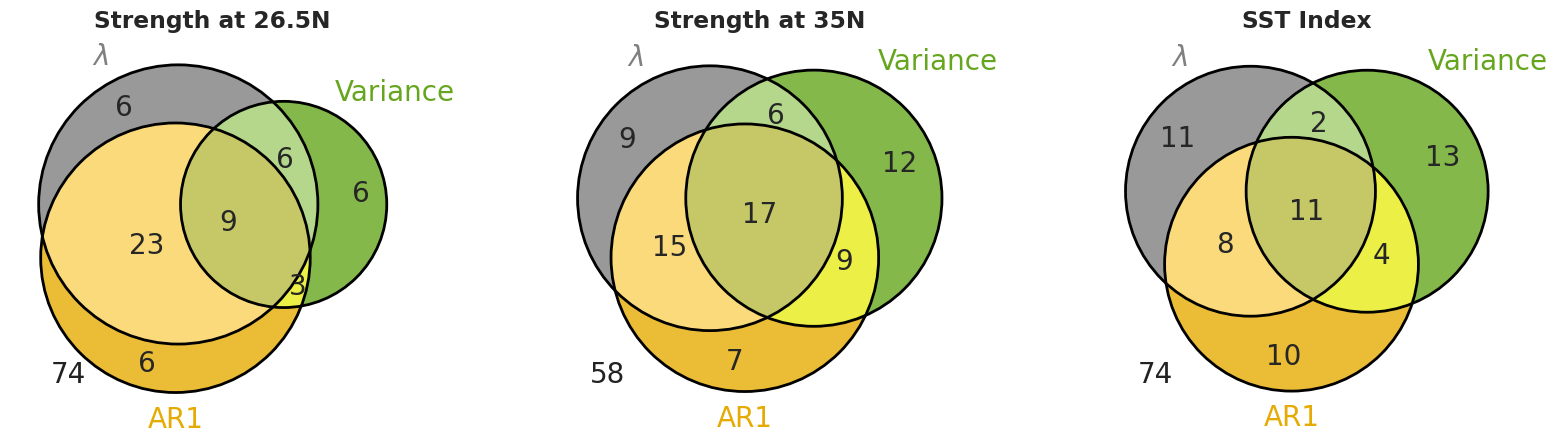

In [146]:
from matplotlib_venn import venn3, venn3_circles
fig = plt.figure(figsize=(20,5))
lbls = ['Strength at 26.5N','Strength at 35N','SST Index']
colorss = ['gray','C4','C5']
for i, subsets in enumerate(subsetss):
    ax = fig.add_subplot(131+i)
    out = venn3(subsets = subsets, set_labels = ('$\lambda$', 'Variance', 'AR1'), alpha = 0.8,set_colors=colorss)
    venn3_circles(subsets = subsets)
    for it, text in enumerate(out.set_labels):
        text.set_fontsize(20)
        text.set_color(colorss[it])
#         text.set_fontweight('bold')
    for text in out.subset_labels:
        text.set_fontsize(20)
    ax.text(0.1,0.1,133-np.sum(subsets),transform=ax.transAxes,ma='left',color='k',fontsize=20)
    ax.set_title(lbls[i],fontweight='bold')
fig.patch.set_facecolor("white")
plt.show()

# everything in slices

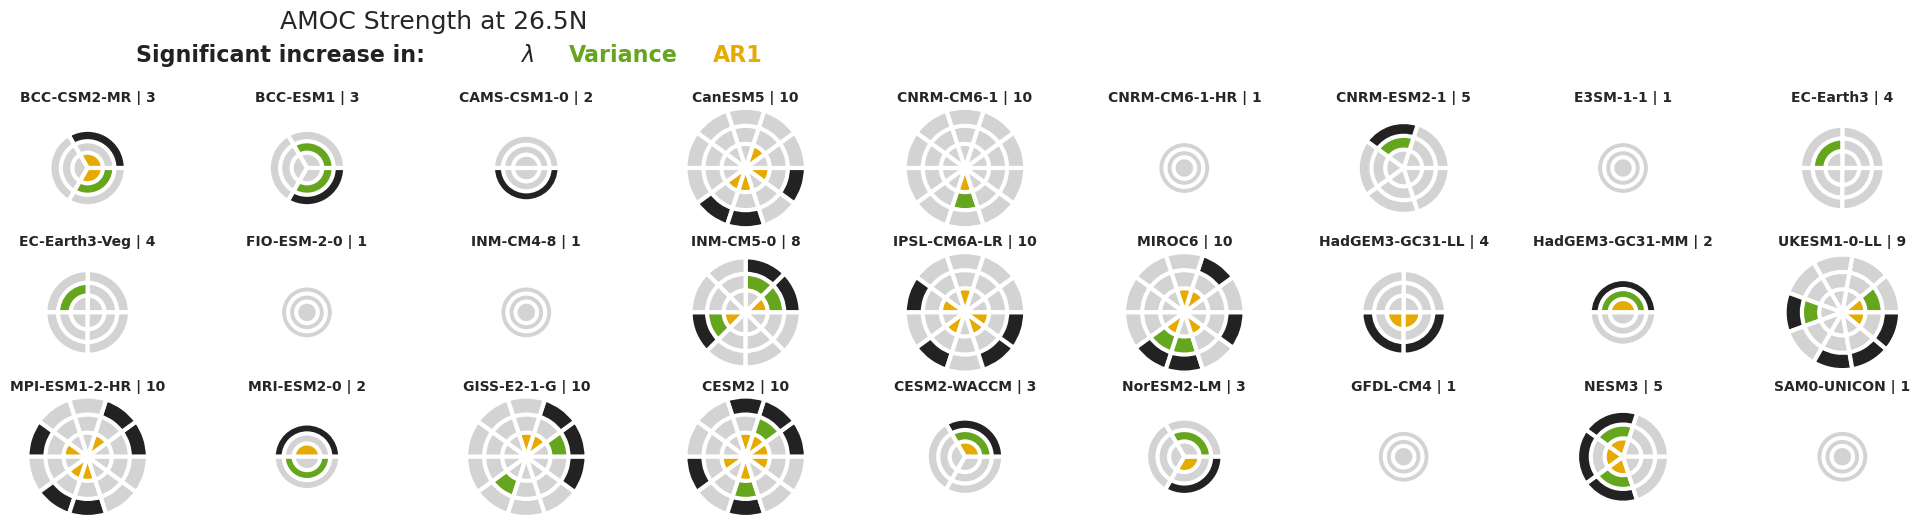

In [44]:
datas = EWS_strn26.sel(indices='strn26')
valuess = all_EWS.pvs.sel(indices='strn26')

fig = plt.figure(figsize=(25,5))
gs = fig.add_gridspec(3, 9)
ir = 0
for im, model in enumerate(models):
    n_tot = np.count_nonzero(~np.isnan(valuess.sel(EWS='var').sel(models=model).values))

    radius = 0.3+0.4*np.sqrt(n_tot)

    if n_tot!= 0:
        if ir<=8:
            ax = fig.add_subplot(gs[0,ir])
        if (ir>=9) & (ir<=17):
            ax = fig.add_subplot(gs[1,ir-9])
        if ir>=18:
            ax = fig.add_subplot(gs[2,ir-18])
            

        ax.set_title('{} | {}'.format(model,n_tot),fontsize=10,fontweight='bold',y=1.1)

        colorss = ['k','C4','C5']
        rads = [1,0.7,0.4]
        ewss = ['lambda','var','ar1']
        idc = np.where(~np.isnan(valuess.sel(EWS='var').sel(models=model).values))

        for i, ews in enumerate(ewss):
            data = (~np.isnan(datas.sel(EWS=ews).sel(models=model).values[idc]))*1
            slices = np.full(len(data),1)
            idc2 = np.where(data==1)
            cols = np.full(len(data),'lightgrey')
            cols[idc2] = colorss[i]
            patches, texts= ax.pie(
            slices,
                radius = rads[i]*radius,
            colors = cols,
            wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
            textprops={'size': 'x-large'})


        ir = ir +1

        if ir==1:
            ax.text(1,1.6,'Significant increase in:',transform=ax.transAxes,fontweight='bold',ma='left',color='k')
            ax.text(5,1.6,'$\lambda$',transform=ax.transAxes,fontweight='bold',ma='left',color='k')
            ax.text(5.5,1.6,'Variance',transform=ax.transAxes,fontweight='bold',ma='left',color='C4')
            ax.text(7,1.6,'AR1',transform=ax.transAxes,fontweight='bold',ma='left',color='C5')
fig.subplots_adjust(hspace=0.5)
#     fig.tight_layout()
fig.patch.set_facecolor("white")

fig.suptitle('AMOC Strength at 26.5N',fontsize=18,y=1.1,x=0.3)
plt.show()

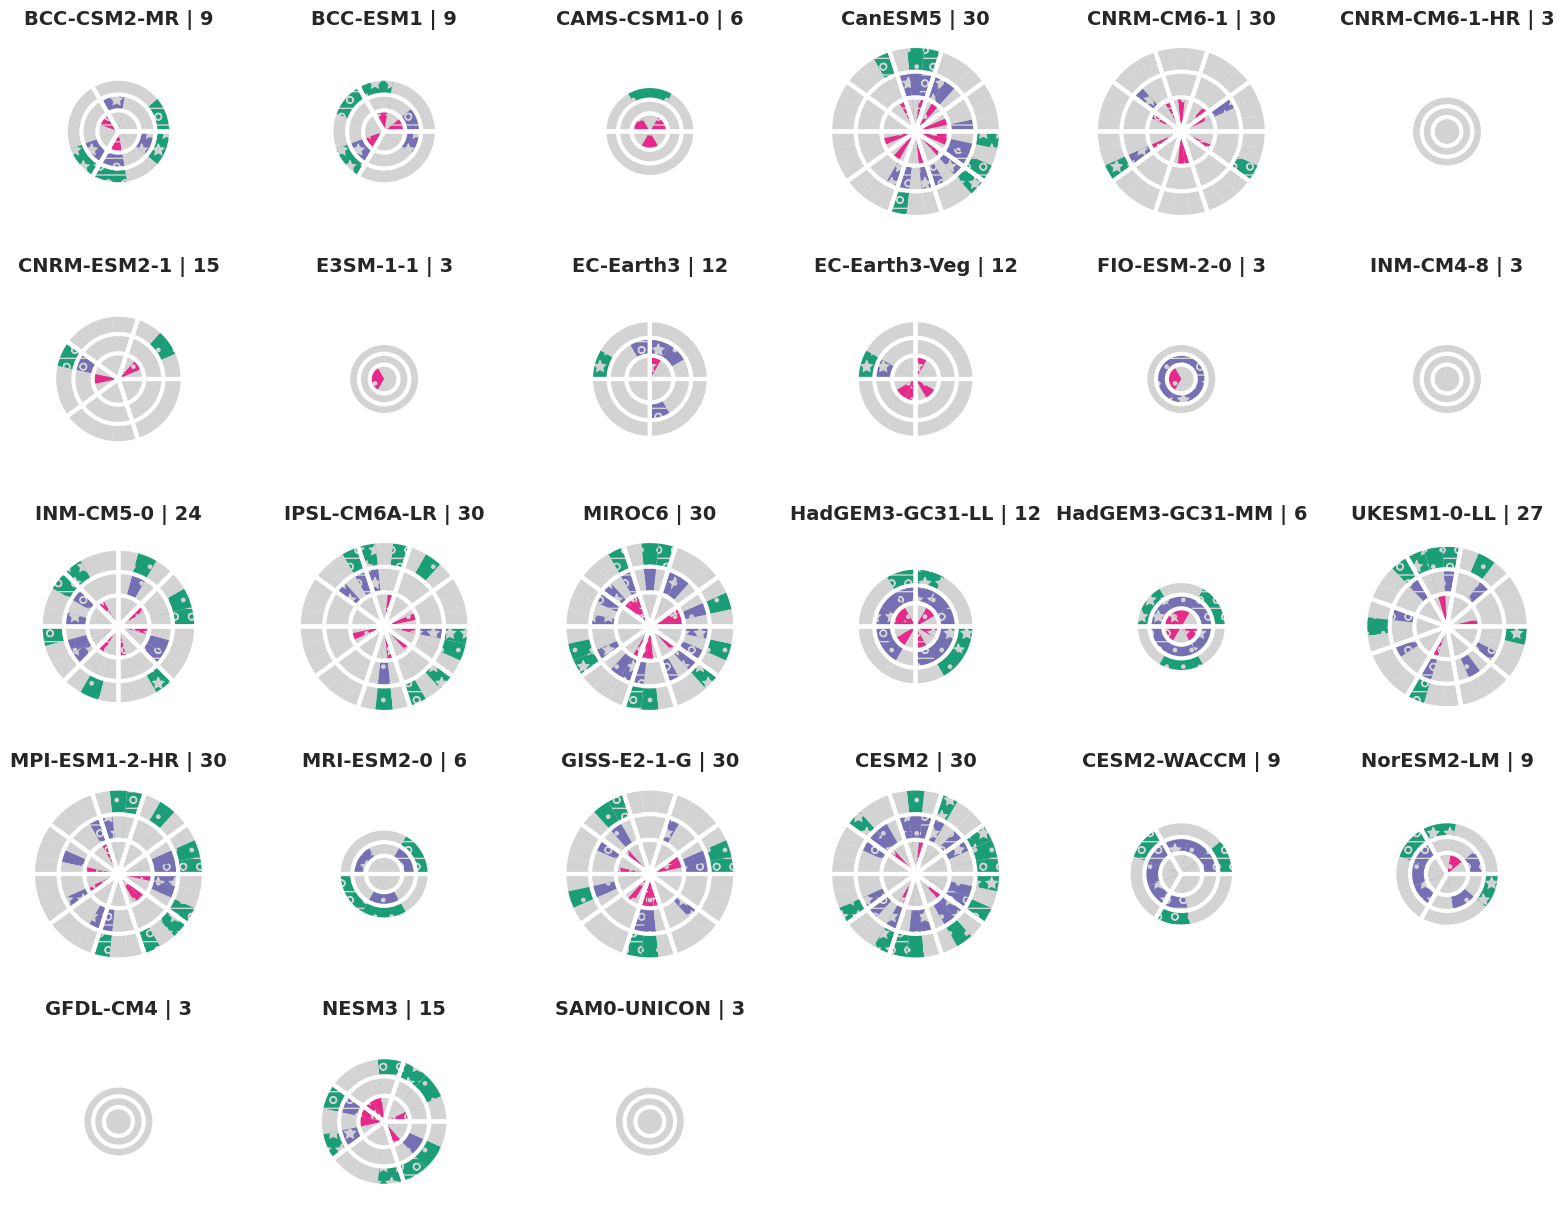

In [92]:
radius_one = 0.3
# for modls in [models[0:12],models[12:22],models[22:]]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(5, 6)
ir = 0
mpl.rcParams['hatch.color'] = 'lightgray'

# datas = 
valuess = all_EWS.pvs.sel(indices='strn26')

for im, model in enumerate(models):
    idc = np.where(~np.isnan(valuess.sel(models=model).values))
    n_tot = np.count_nonzero(~np.isnan(valuess.sel(models=model).values)) # three times the ensm mem number


    radius = 0.2+0.2*np.sqrt(n_tot)

    if n_tot!= 0:
        if ir<=5:
            ax = fig.add_subplot(gs[0,ir])
        if (ir>=6) & (ir<=11):
            ax = fig.add_subplot(gs[1,ir-6])
        if (ir>=12) & (ir<=17):
            ax = fig.add_subplot(gs[2,ir-12])
        if (ir>=18) & (ir<=23):
            ax = fig.add_subplot(gs[3,ir-18])
        if (ir>=24):
            ax = fig.add_subplot(gs[4,ir-24])

        ax.set_title('{} | {}'.format(model,n_tot),fontsize=14,fontweight='bold',y=1.1)
        
        colorss = ['C0','C2','C3']
        rads = [1,0.7,0.4]
        datass = [EWS_strn26.sel(indices='strn26'),EWS_strn35.sel(indices='strn35'),EWS_index.sel(indices='index')]
        ewss = ['lambda','var','ar1']
#         idc = np.where(~np.isnan(valuess.sel(EWS='var').sel(models=model).values))

            
        for i, datas in enumerate(datass):
            data = (~np.isnan(datas.sel(models=model).values[idc]))*1 # flattened 3 EWS into list in order of ewss
            slices = np.full(len(data),1)
#             idc1 = 
            idc2 = np.where(data==1)
            cols = np.full(len(data),'lightgrey')
            cols[idc2] = colorss[i]
            patches, texts= ax.pie(
            slices,
                radius = rads[i]*radius,
            colors = cols,
#             wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
            textprops={'size': 'x-large'})
            patterns = ['o-','.','*']
            for j in range(len(patches)):
                patches[j].set_hatch(patterns[(j)%len(patterns)])
            
            slices2 = np.full(int(len(data)/3),1)
            cols = np.full(len(data),'lightgrey')
            patches, texts= ax.pie(
            slices2,
                radius = rads[i]*radius,
            colors = None,
            wedgeprops={'linewidth': 3.0, 'edgecolor': 'white','facecolor':None,'fill':False},
            textprops={'size': 'x-large'})

        ir = ir +1
        
#         if ir==27:
#             ax.text(1.5,1,'Significantly\nincreasing $\lambda$ in:',transform=ax.transAxes,fontweight='bold',ma='left',color='k',fontsize=20)
#             ax.text(1.5,0.7,'Strn 26.5N',transform=ax.transAxes,fontweight='bold',ma='left',color='C0',fontsize=20)
#             ax.text(1.5,0.5,'Strn 35N',transform=ax.transAxes,fontweight='bold',ma='left',color='C2',fontsize=20)
#             ax.text(1.5,0.3,'SST Index',transform=ax.transAxes,fontweight='bold',ma='left',color='C3',fontsize=20)
fig.subplots_adjust(hspace=0.5)
#     fig.tight_layout()
fig.patch.set_facecolor("white")
plt.show()

In [95]:
EWS_lambda = all_EWS.pvs.sel(EWS='lambda').where(
           (all_EWS.pvs.sel(EWS='lambda')<=min_pv))
EWS_var = all_EWS.pvs.sel(EWS='var').where(
           (all_EWS.pvs.sel(EWS='var')<=min_pv))
EWS_ar1 = all_EWS.pvs.sel(EWS='ar1').where(
           (all_EWS.pvs.sel(EWS='ar1')<=min_pv))

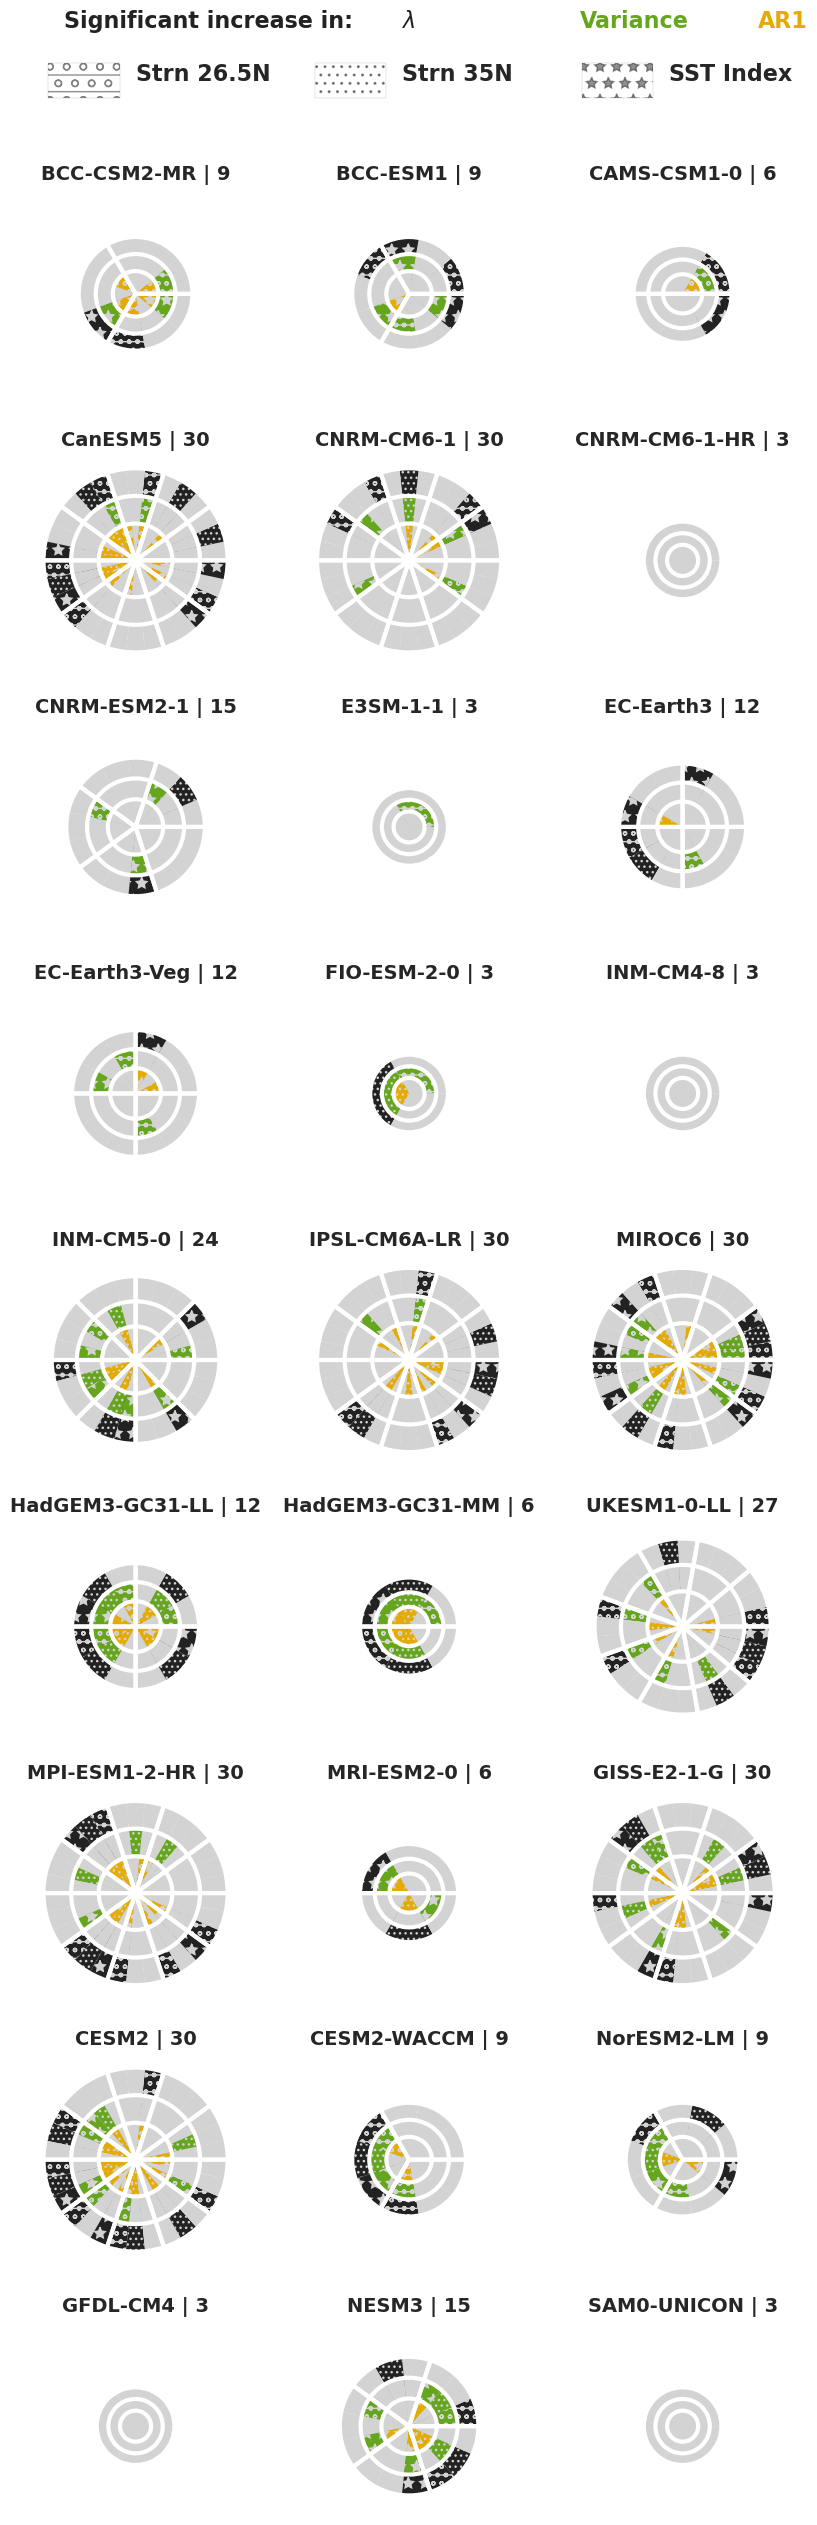

In [125]:
radius_one = 0.3
# for modls in [models[0:12],models[12:22],models[22:]]:
fig = plt.figure(figsize=(10,30))
gs = fig.add_gridspec(9, 3)
ir = 0
mpl.rcParams['hatch.color'] = 'lightgray'

valuess = all_EWS.pvs.sel(EWS='var')

for im, model in enumerate(models):
    idc = np.where(~np.isnan(valuess.sel(models=model).values))
    n_tot = np.count_nonzero(~np.isnan(valuess.sel(models=model).values)) # three times the ensm mem number


    radius = 0.2+0.2*np.sqrt(n_tot)

    if n_tot!= 0:
        ax = fig.add_subplot(gs[int((ir - ir%3)/3),ir%3])

        ax.set_title('{} | {}'.format(model,n_tot),fontsize=14,fontweight='bold',y=1.1)
        
        colorss = ['k','C4','C5']
        rads = [1,0.7,0.4]
        datass = [EWS_lambda,EWS_var,EWS_ar1]
#         datass = [EWS_strn26.sel(indices='strn26'),EWS_strn35.sel(indices='strn35'),EWS_index.sel(indices='index')]
#         ewss = ['lambda','var','ar1']
        
#         idc = np.where(~np.isnan(valuess.sel(EWS='var').sel(models=model).values))

            
        for i, datas in enumerate(datass):
            data = (~np.isnan(datas.sel(models=model).values[idc]))*1 # flattened 3 EWS into list in order of ewss
            slices = np.full(len(data),1)
#             idc1 = 
            idc2 = np.where(data==1)
            cols = np.full(len(data),'lightgrey')
            cols[idc2] = colorss[i]
            patches, texts= ax.pie(
            slices,
                radius = rads[i]*radius,
            colors = cols,
#             wedgeprops={'linewidth': 0.5, 'edgecolor': 'white'},
            textprops={'size': 'x-large'})
            patterns = ['oo-','...','*']
            for j in range(len(patches)):
                patches[j].set_hatch(patterns[(j)%len(patterns)])
            
            slices2 = np.full(int(len(data)/3),1)
            cols = np.full(len(data),'lightgrey')
            patches, texts= ax.pie(
            slices2,
                radius = rads[i]*radius,
            colors = None,
            wedgeprops={'linewidth': 3.0, 'edgecolor': 'white','facecolor':None,'fill':False},
            textprops={'size': 'x-large'})

        ir = ir +1
        
        if ir==1:
            ax.text(0.1,2,'Significant increase in:',transform=ax.transAxes,fontweight='bold',ma='left',color='k')
            ax.text(2,2,'$\lambda$',transform=ax.transAxes,fontweight='bold',ma='left',color='k')
            ax.text(3,2,'Variance',transform=ax.transAxes,fontweight='bold',ma='left',color='C4')
            ax.text(4,2,'AR1',transform=ax.transAxes,fontweight='bold',ma='left',color='C5')
            ax.text(0.5,1.7,'Strn 26.5N',transform=ax.transAxes,fontweight='bold')
            leg_rect2 = mpl.patches.Rectangle((0.01,1.6), 0.4, 0.2, transform=ax.transAxes,fill=False,alpha=0.5,edgecolor='k',hatch='o-',clip_on=False)
            ax.add_patch(leg_rect2)
            ax.text(2,1.7,'Strn 35N',transform=ax.transAxes,fontweight='bold')
            leg_rect2 = mpl.patches.Rectangle((1.51,1.6), 0.4, 0.2, transform=ax.transAxes,fill=False,alpha=0.5,edgecolor='k',hatch='..',clip_on=False)
            ax.add_patch(leg_rect2)
            ax.text(3.5,1.7,'SST Index',transform=ax.transAxes,fontweight='bold')
            leg_rect2 = mpl.patches.Rectangle((3.01,1.6), 0.4, 0.2, transform=ax.transAxes,fill=False,alpha=0.5,edgecolor='k',hatch='*',clip_on=False)
            ax.add_patch(leg_rect2)

fig.subplots_adjust(hspace=0.5)
#     fig.tight_layout()
fig.patch.set_facecolor("white")
plt.show()

# ratios

In [126]:
def EWS_intersections(data):
    EWS_all_ind = data.sel(EWS='lambda').where(
           ((data.sel(EWS='lambda')<=min_pv)&
            (data.sel(EWS='var')<=min_pv)&
            (data.sel(EWS='ar1')<=min_pv)))
    EWS_lambda = data.sel(EWS='lambda').where(
               (data.sel(EWS='lambda')<=min_pv))
    EWS_var = data.sel(EWS='lambda').where(
               (data.sel(EWS='var')<=min_pv))
    EWS_ar1 = data.sel(EWS='lambda').where(
               (data.sel(EWS='ar1')<=min_pv))

    EWS_any = data.sel(EWS='lambda').where(
               ((data.sel(EWS='lambda')<=min_pv) |
                (data.sel(EWS='var')<=min_pv) |
                (data.sel(EWS='ar1')<=min_pv)))
    EWS_lamvar = data.sel(EWS='lambda').where(
               (data.sel(EWS='lambda')<=min_pv)&
                (data.sel(EWS='var')<=min_pv))
    EWS_varar1 = data.sel(EWS='lambda').where(
               (data.sel(EWS='var')<=min_pv)&
                (data.sel(EWS='ar1')<=min_pv))
    EWS_lamar1 = data.sel(EWS='lambda').where(
               (data.sel(EWS='lambda')<=min_pv)&
                (data.sel(EWS='ar1')<=min_pv))
    return EWS_all_ind, EWS_lambda, EWS_var, EWS_ar1, EWS_any, EWS_lamvar, EWS_varar1, EWS_lamar1

In [128]:
def count_intersections(data, EWS_all_ind, EWS_lambda, EWS_var, EWS_ar1, EWS_any, EWS_lamvar, EWS_varar1, EWS_lamar1):
    N_tot = np.count_nonzero(~np.isnan(data.sel(EWS='ar1').values))
    N_all = np.count_nonzero(~np.isnan(EWS_all_ind.values))
    N_lam = np.count_nonzero(~np.isnan(EWS_lambda.values))
    N_var = np.count_nonzero(~np.isnan(EWS_var.values))
    N_ar1 = np.count_nonzero(~np.isnan(EWS_ar1 .values))
    N_any = np.count_nonzero(~np.isnan(EWS_any.values))
    N_lamvar = np.count_nonzero(~np.isnan(EWS_lamvar.values))
    N_varar1 = np.count_nonzero(~np.isnan(EWS_varar1.values))
    N_lamar1 = np.count_nonzero(~np.isnan(EWS_lamar1.values))
    return N_tot, N_all, N_lam, N_var, N_ar1, N_any, N_lamvar, N_varar1, N_lamar1

In [132]:
min_pv = 0.05
indx = 'strn26'
model = 'CESM2'
data = all_EWS.pvs.sel(indices=indx).sel(models=model)

EWS_all_ind, EWS_lambda, EWS_var, EWS_ar1, EWS_any, EWS_lamvar, EWS_varar1, EWS_lamar1 = EWS_intersections(data)
N_tot, N_all, N_lam, N_var, N_ar1, N_any, N_lamvar, N_varar1, N_lamar1 = count_intersections(data, EWS_all_ind, EWS_lambda, EWS_var, EWS_ar1, EWS_any, EWS_lamvar, EWS_varar1, EWS_lamar1)


y = (N_lamvar+N_varar1+N_lamar1-2*N_all)/N_any
x = N_any/N_tot

strn26
13
strn35
13
index
13


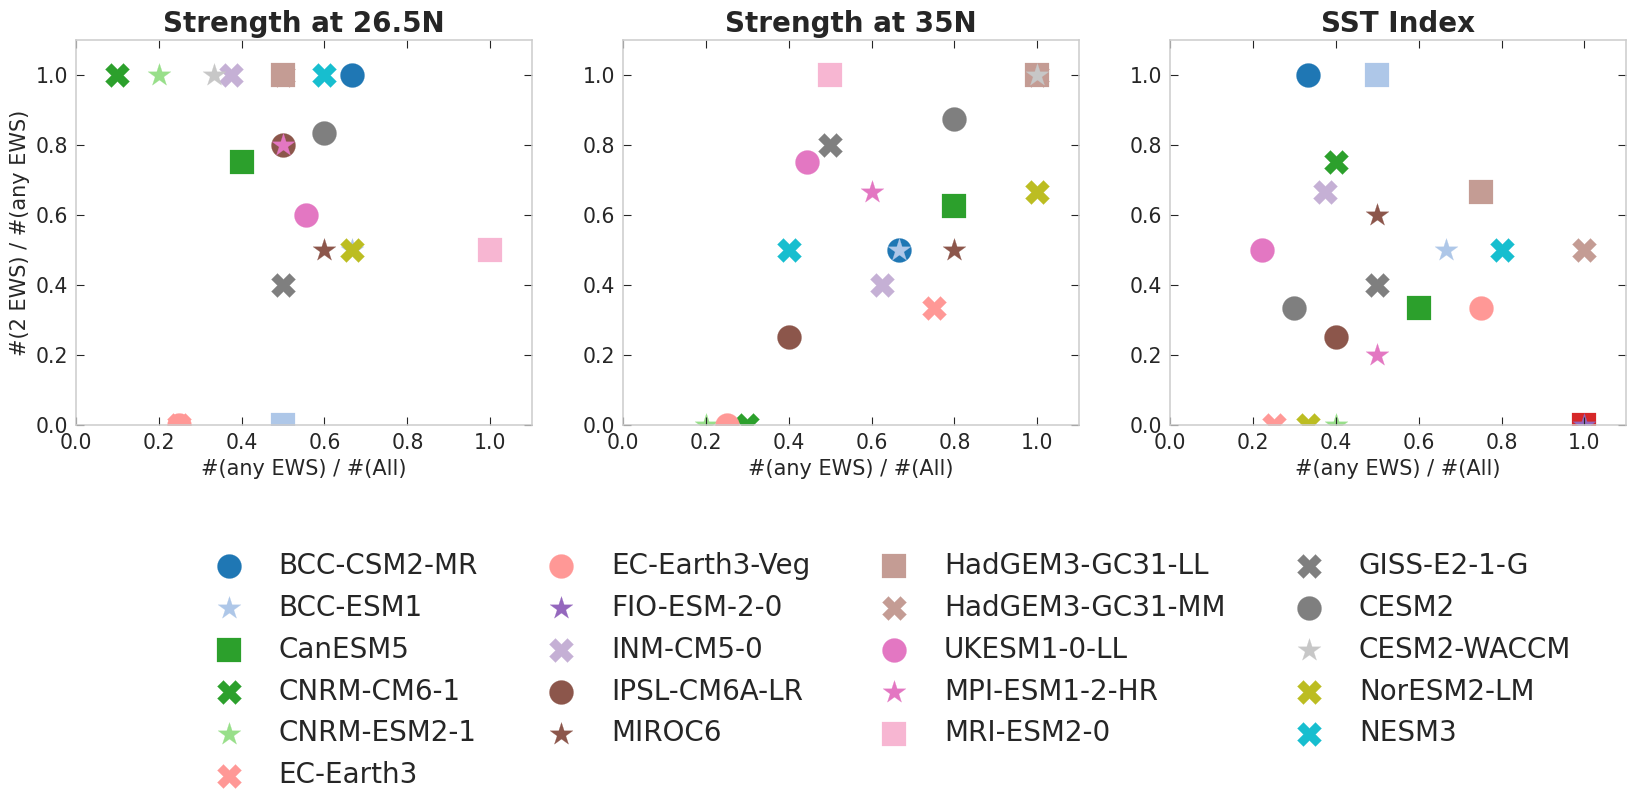

In [172]:
ewss = ['lambda','var','ar1']
indices = ['strn26','strn35','index']
cols = ['C0','C2','C3']
cmap = plt.get_cmap('tab20')
color_list = [cmap(i/34) for i in np.arange(0,34)]
markers = ['X','o','*','s']
lbls = ['Strength at 26.5N','Strength at 35N','SST Index']

fig = plt.figure(figsize = (20,5))
for ind, indx in enumerate(indices):
    print(indx)
    ax = fig.add_subplot(131+ind)
    none = 0

    for im, model in enumerate(models):
        data = all_EWS.pvs.sel(indices=indx).sel(models=model)
        marker = markers[im%4]
        col = color_list[im]
        EWS_all_ind, EWS_lambda, EWS_var, EWS_ar1, EWS_any, EWS_lamvar, EWS_varar1, EWS_lamar1 = EWS_intersections(data)
        N_tot, N_all, N_lam, N_var, N_ar1, N_any, N_lamvar, N_varar1, N_lamar1 = count_intersections(data, EWS_all_ind, EWS_lambda, EWS_var, EWS_ar1, EWS_any, EWS_lamvar, EWS_varar1, EWS_lamar1)
        if N_any != 0:
            y = (N_lamvar+N_varar1+N_lamar1-2*N_all)/N_any
            x = N_any/N_tot
            ax.scatter(x,y,color=col,marker=marker,label=model,s=300)
        else:
            none = none+1
    if ind==1:
        ax.legend(bbox_to_anchor=(-0.95, -0.3), loc='upper left', borderaxespad=0., fontsize=20,fancybox=False,frameon=False,ncol=4)
    ax.set_xlim(0,1.1)
    ax.set_ylim(0,1.1)
    ax.set_title(lbls[ind],fontsize=20,fontweight='bold')
    ax.set_xlabel('#(any EWS) / #(All)',fontsize=15)
    if ind==0:
        ax.set_ylabel('#(2 EWS) / #(any EWS)',fontsize=15)
    print(none)
plt.show()



In [139]:
markers = ['.','^','>',1,'s','P','*','+','d','X']